In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [3]:
from configs import probe_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: '1'
  categories:
  - 3
  - 47
  - 11
  - 2
  - 2
  - 2
  dataset: probe
  label_column: class
  numerical_features: 0
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: best
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.001
  optimizer: AdamW
  scheduler: cosine
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      - swish
    model_dropout:
      values:
      - 0.0
      - 0.1
      - 0.2
      - 0.3
      - 0.4
      - 0.5
    model_embedding_type:
      v

In [4]:
sum(config.data.categories)

67

In [5]:
assert config.data.dataset == "probe"

In [6]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/probe/'

In [7]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis


def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train, X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(5,6,1),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [8]:
# Load baseline results 
baseline_metrics = pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0)
baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
          count       mean        std        min        25%        50%   
model                                                                    
DAGMM       5.0  78.182917  13.313098  54.682918  82.211946  82.774239   
DSVDD       5.0  85.285568  13.623143  64.606184  78.523890  91.405524   
ECOD        5.0  98.007423   0.090644  97.918444  97.961341  97.999158   
IForest     5.0  96.311175   0.856994  95.189573  95.588612  96.839989   

                                 ap                                  \
               75%        max count       mean       std        min   
model                                                                 
DAGMM    83.538381  87.707102   5.0  66.399856  9.431388  50.047984   
DSVDD    94.487658  97.404586   5.0  89.156808  8.397735  76.924159   
ECOD     98.000075  98.158096   5.0  95.389151  0.383807  95.013909   
IForest  96.888387  97.049314   5.0  92.945700  2.284513  90.450928   

                                                     
               25%        50%        75%        max  
model                                                
DAGMM    67.963122  69.446517  70.301302  74.240352  
DSVDD    83.973640  93.252222  95.598057  96.035965  
ECOD     95.043971  95.458654  95.477338  95.951884  
IForest  90.458343  94.249797  94.768398  94.801034

========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 91.378954 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
91.378954 (2.575844) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


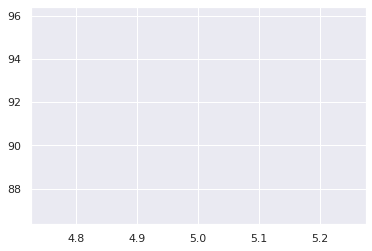

---Likelihoods---
Training: 110.243
Inlier: 107.477
Outlier: -350.738
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 90.111849 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
90.111849 (7.535220) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


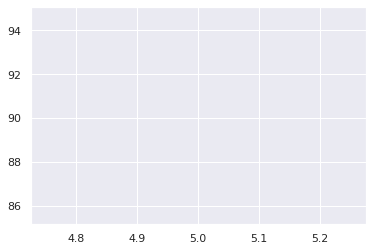

---Likelihoods---
Training: 117.698
Inlier: 114.778
Outlier: -297.883
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 76.916253 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
76.916253 (21.898241) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


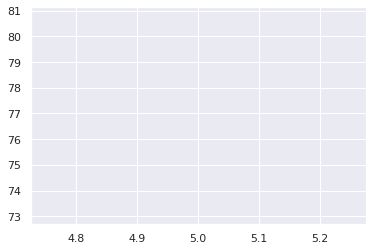

---Likelihoods---
Training: 110.293
Inlier: 106.546
Outlier: -205.252
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 90.836011 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
90.836011 (7.843064) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


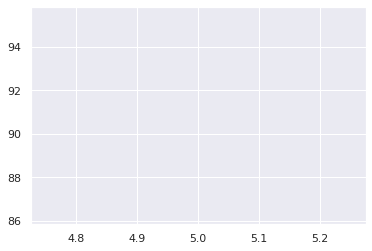

---Likelihoods---
Training: 110.640
Inlier: 107.060
Outlier: -66.750
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 61.217117 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
61.217117 (31.097915) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


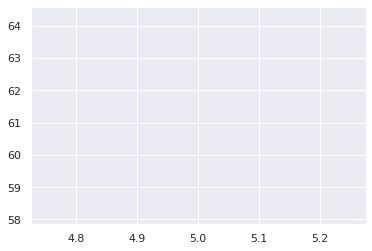

---Likelihoods---
Training: 115.945
Inlier: 112.281
Outlier: -385.667
========================= Training KD Tree =========================


In [9]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [10]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,96.874974,3.871922,0.300380,0.300380,97.128575,94.386603,96.284186,2.000000
std,0.734166,0.539250,0.368569,0.368569,0.931578,4.182803,2.012351,1.581139
min,96.223307,3.397352,0.049513,0.049513,96.361574,91.095314,94.731428,0.000000
25%,96.346404,3.504630,0.066017,0.066017,96.407086,91.161956,94.834462,1.000000
50%,96.458671,3.735691,0.115531,0.115531,96.585035,91.756912,94.881083,2.000000
75%,97.627633,3.969722,0.346592,0.346592,98.109234,98.870209,98.408984,3.000000
max,97.718858,4.752216,0.924245,0.924245,98.179947,99.048622,98.564975,4.000000


In [11]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"
kd_metrics

kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,87.959902,10.201342,0.151840,0.151840,93.877463,93.865735,89.844377,2.000000
std,1.304714,1.082383,0.075090,0.075090,0.651981,0.599337,1.111287,1.581139
min,87.340349,8.266340,0.082522,0.082522,93.517614,93.579156,89.321149,0.000000
25%,87.349188,10.650958,0.132035,0.132035,93.540576,93.598776,89.343842,1.000000
50%,87.384418,10.663713,0.132035,0.132035,93.618317,93.600150,89.348546,2.000000
75%,87.432611,10.675715,0.132035,0.132035,93.672279,93.612948,89.376351,3.000000
max,90.292942,10.749985,0.280574,0.280574,95.038530,94.937644,91.831997,4.000000


In [12]:
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
           count       mean        std        min        25%        50%   
model                                                                     
DAGMM        5.0  78.182917  13.313098  54.682918  82.211946  82.774239   
DSVDD        5.0  85.285568  13.623143  64.606184  78.523890  91.405524   
ECOD         5.0  98.007423   0.090644  97.918444  97.961341  97.999158   
IForest      5.0  96.311175   0.856994  95.189573  95.588612  96.839989   
MSMA-GMM     5.0  96.284186   2.012351  94.731428  94.834462  94.881083   
MSMA-KD      5.0  89.844377   1.111287  89.321149  89.343842  89.348546   

                                  ap                                  \
                75%        max count       mean       std        min   
model                                                                  
DAGMM     83.538381  87.707102   5.0  66.399856  9.431388  50.047984   
DSVDD     94.487658  97.404586   5.0  89.156808  8.397735  76.924159   
ECOD      98.000075  98.158096   5.0  95.389151  0.383807  95.013909   
IForest   96.888387  97.049314   5.0  92.945700  2.284513  90.450928   
MSMA-GMM  98.408984  98.564975   5.0  96.874974  0.734166  96.223307   
MSMA-KD   89.376351  91.831997   5.0  87.959902  1.304714  87.340349   

                                                      
                25%        50%        75%        max  
model                                                 
DAGMM     67.963122  69.446517  70.301302  74.240352  
DSVDD     83.973640  93.252222  95.598057  96.035965  
ECOD      95.043971  95.458654  95.477338  95.951884  
IForest   90.458343  94.249797  94.768398  94.801034  
MSMA-GMM  96.346404  96.458671  97.627633  97.718858  
MSMA-KD   87.349188  87.384418  87.432611  90.292942

In [13]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of probe: 4166/10225 = 0.41


In [14]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} \pm~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.41 & 92.95 \pm~2.28 & 95.39 \pm~0.38 & 66.40 \pm~9.43 & 89.16 \pm~8.40 & \B 96.87 \pm~0.73
roc_auc & 0.41 & 96.31 \pm~0.86 & \B 98.01 \pm~0.09 & 78.18 \pm~13.31 & 85.29 \pm~13.62 & 96.28 \pm~2.01


In [15]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

,model,metric,value
0,MSMA-GMM,ap,96.458671
1,MSMA-GMM,ap,97.718858
2,MSMA-GMM,ap,96.223307
3,MSMA-GMM,ap,96.346404
4,MSMA-GMM,ap,97.627633
...,...,...,...
205,DSVDD,roc_auc,64.606184
206,DSVDD,roc_auc,94.487658
207,DSVDD,roc_auc,91.405524
208,DSVDD,roc_auc,78.523890


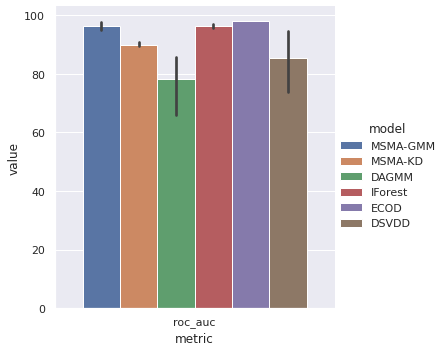

In [16]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

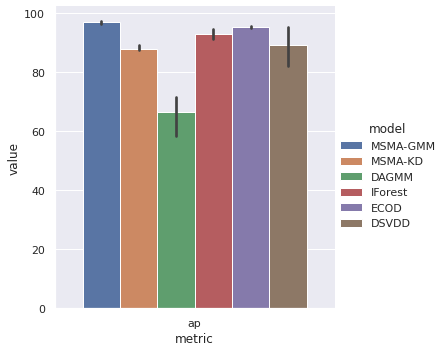

In [17]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")